     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107721 sha256=bfc8ee0ca24813862d96a78aea3b8f34f2c305ac8d635594189195690a669738
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5
Mounted at /content/drive
Counter({'Infiltrating Ductal Carcinoma': 766, 'Infiltrating Lobular Carcinoma': 184, 'Other, specify': 48, 'Mixed Histology (please specify)': 28, 'Mucinou

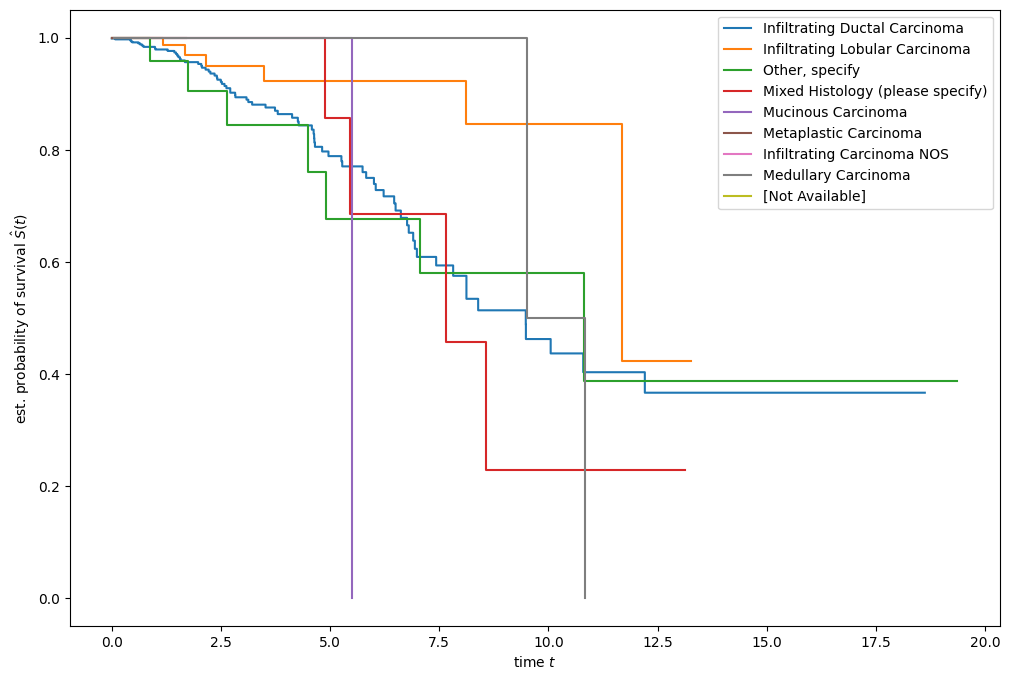

In [1]:
# 1. Setup, change drive mounted file path to desired path

import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import json
!pip install scikit-survival

from google.colab import drive
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_ipcw, concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

!pip install eli5
#import eli5
#from eli5.sklearn import PermutationImportance

#%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

drive.mount('/content/drive')

pd.options.display.max_columns = None
pd.options.display.precision = 4


random_state = 20

## create a result output folder:
OUTPUT_FOLDER = f"Survival_analysis_penalizedCox_rfe.predictions.reproduce.auc"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)


clinic_info = pd.read_csv("/content/drive/MyDrive/Takeout/breastCancer/clinical_brca.csv")
clinical_features = [
    "age_at_diagnosis", "ajcc_pathologic_tumor_stage",
    "er_status_by_ihc", "pr_status_by_ihc", "her2_status_by_ihc",
]

l = ["[Not Available]", "[Not Evaluated]", "Indeterminate",
     "Infiltrating Carcinoma NOS", "Mixed Histology (please specify)", "Other, specify"]
clinic_info[clinical_features] = clinic_info[clinical_features].replace(l, value=np.nan)

stage_map = {
    'Stage IA': 'Stage I', 'Stage IB': 'Stage I',
    'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II',
    'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III', 'Stage IIIC': 'Stage III',
    'Stage X': np.nan, '[Discrepancy]': np.nan, '[Not Available]': np.nan,
}
clinic_info['ajcc_pathologic_tumor_stage']= clinic_info['ajcc_pathologic_tumor_stage'].replace(stage_map)

f = open('/content/drive/MyDrive/Takeout/breastCancer/data_x.json')
data = json.load(f)
slides_info = pd.DataFrame.from_dict(data, orient='index')
slides_info = slides_info.drop(['kde'], axis=1)
slides_info['hausdorff'] = slides_info['hausdorff'].apply(lambda x: x[0])
slides_info.index = slides_info.index.str.slice(0, 12)
slides_info = slides_info.reset_index()
slides_info.rename(columns={'index': 'bcr_patient_barcode'}, inplace=True)

#slides_info = pd.read_csv("./features_results/nuclei_features_merged.csv")
image_features = slides_info.columns.tolist()[1:]
#assert len(slides_info['bcr_patient_barcode'].unique()) == len(slides_info)

## Merge:
df = clinic_info.merge(slides_info, how='inner', on='bcr_patient_barcode')
df['event'] = df['event'] > 0
print(Counter(df['histological_type']))

df = df[df.time > 0]

## general survival for different histological type
h_types = df['histological_type'][~df['histological_type'].isna()].unique()
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
for h_type in h_types:
    sub_df = df.loc[df['histological_type'] == h_type, ]
    time, prob = kaplan_meier_estimator(
        sub_df['event'], sub_df['time']/365)

    axes.step(time, prob, where="post", label=f"{h_type}")

axes.set_ylabel("est. probability of survival $\hat{S}(t)$")
axes.set_xlabel("time $t$")
axes.legend(loc="best")
plt.show()


In [ ]:
params = ['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']

train_log = X_train.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for i in params:
  train_log[i] = train_log[i].map(lambda a: np.log10(a))

train_log[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']] = scaler.fit_transform(train_log[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']])

hist = train_log[params].hist(bins=10)
X_train = train_log
#train_log

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [5]:
# 3. Standard scale datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']] = scaler.fit_transform(X_train[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']])
X_test[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']] = scaler.fit_transform(X_test[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']])


In [6]:
# 4. Create covariate dataset

covariate_train = pd.merge(df_train_c, slides_info, how='inner', on='bcr_patient_barcode')
covariate_test = pd.merge(df_test_c, slides_info, how='inner', on='bcr_patient_barcode')
covariate_train['covariate'] = 1
covariate_test['covariate'] = 0
covariate = pd.concat([covariate_train, covariate_test])
covariate[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']] = scaler.fit_transform(covariate[['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']])

covariate

,bcr_patient_barcode,time,event,histological_type,age_at_diagnosis,ajcc_pathologic_tumor_stage,er_status_by_ihc,pr_status_by_ihc,her2_status_by_ihc,t.count.prob,s.count.prob,l.count.prob,t_t.edges.marginal.prob,t_s.edges.marginal.prob,t_l.edges.marginal.prob,s_s.edges.marginal.prob,s_l.edges.marginal.prob,l_l.edges.marginal.prob,t_s.edges.conditional.prob,t_l.edges.conditional.prob,s_t.edges.conditional.prob,s_l.edges.conditional.prob,l_t.edges.conditional.prob,l_s.edges.conditional.prob,t_s.cos,t_l.cos,s_l.cos,t_s.proj.prob,s_t.proj.prob,t_l.proj.prob,l_t.proj.prob,s_l.proj.prob,l_s.proj.prob,hausdorff,mean_kde,emd,jaccard,tumorDensity,lymphoDensity,max_hausdorff,wasserstein,log_density,divergence,covariate
0,TCGA-3C-AALI,3801,0,1.0,0.50,2,1,1,1,0.8470,0.0702,0.0828,0.7729,0.0828,0.0610,0.0231,0.0182,0.0419,0.6671,0.5040,0.0903,0.1502,0.0666,0.1465,0.2433,0.0758,0.2832,0.3519,0.0983,0.1857,0.0246,0.2764,0.1736,-0.5457,-0.0720,-0.6027,-0.7024,-0.0426,-0.0963,-0.0734,-0.5090,-0.7538,-0.2299,1
1,TCGA-3C-AALI,3801,0,1.0,0.50,2,1,1,1,0.8470,0.0702,0.0828,0.7729,0.0828,0.0610,0.0231,0.0182,0.0419,0.6671,0.5040,0.0903,0.1502,0.0666,0.1465,0.2433,0.0758,0.2832,0.3519,0.0983,0.1857,0.0246,0.2764,0.1736,1.4219,-0.0737,0.0187,0.0134,-0.0958,-0.2056,0.4963,0.0498,-1.0295,0.4139,1
2,TCGA-3C-AALJ,1228,0,1.0,0.62,2,1,1,0,0.7337,0.2414,0.0249,0.6356,0.1828,0.0145,0.1415,0.0179,0.0076,0.5342,0.3630,0.2195,0.4476,0.0174,0.0524,0.2974,0.1048,0.2837,0.4070,0.1142,0.5409,0.0092,0.5802,0.0550,-0.6052,-0.0694,0.4953,-0.9641,-1.0718,1.2787,0.6834,-0.3315,0.1719,-0.1653,1
3,TCGA-3C-AALJ,1228,0,1.0,0.62,2,1,1,0,0.7337,0.2414,0.0249,0.6356,0.1828,0.0145,0.1415,0.0179,0.0076,0.5342,0.3630,0.2195,0.4476,0.0174,0.0524,0.2974,0.1048,0.2837,0.4070,0.1142,0.5409,0.0092,0.5802,0.0550,-0.5969,-0.0740,-0.6694,-0.9185,-0.9863,0.3544,-0.4628,-0.6724,-0.3001,-0.2983,1
4,TCGA-3C-AALK,1217,0,1.0,0.52,1,1,1,1,0.7597,0.2106,0.0297,0.6873,0.1191,0.0198,0.1431,0.0223,0.0084,0.4187,0.3921,0.1442,0.4412,0.0239,0.0783,0.2909,0.0693,0.2740,0.3466,0.1376,0.1969,0.0192,0.3469,0.1238,-0.5931,-0.0693,-0.2234,-0.6770,-0.6309,-0.0460,-0.0262,-0.1017,0.3362,-0.0780,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,TCGA-HN-A2OB,1849,0,0.0,0.45,2,1,1,-1,0.7310,0.2371,0.0319,0.6525,0.1214,0.0315,0.1698,0.0173,0.0075,0.3935,0.5600,0.1507,0.3072,0.0391,0.0560,0.2396,0.1782,0.3210,0.2818,0.1276,0.5986,0.0209,0.6212,0.0591,1.2204,-0.0077,1.4890,1.0035,5.4006,-0.4106,0.5860,1.8750,0.5285,-0.0842,0
170,TCGA-LD-A7W5,124,0,1.0,0.52,3,1,1,-1,0.7115,0.2168,0.0717,0.6233,0.1290,0.0416,0.1370,0.0377,0.0314,0.5034,0.4693,0.1801,0.3499,0.0583,0.1196,0.2900,0.1651,0.4395,0.2655,0.1887,0.2939,0.0614,0.4706,0.1785,-0.4843,-0.0724,-0.7411,1.5818,-0.0007,-0.2705,-0.9190,-0.6871,-0.7843,-0.5891,0
171,TCGA-LD-A9QF,266,0,1.0,0.73,1,-1,-1,1,0.6315,0.2650,0.1036,0.4952,0.1883,0.0831,0.1311,0.0786,0.0236,0.4731,0.4485,0.2456,0.4241,0.1084,0.1975,0.2045,0.0887,0.4569,0.1246,0.2271,0.1128,0.0583,0.4848,0.1816,0.4454,-0.0307,0.3102,-0.4606,-0.4855,-0.2267,-0.1687,0.6484,1.2036,0.2192,0
172,TCGA-LL-A50Y,210,0,0.0,0.84,2,1,1,0,0.6955,0.2182,0.0863,0.5987,0.1296,0.0605,0.1270,0.0566,0.0277,0.4138,0.4179,0.1643,0.3909,0.0767,0.1807,0.3284,0.1512,0.3160,0.3467,0.1689,0.2530,0.0633,0.3046,0.1857,0.0739,-0.0613,-0.3689,0.5271,0.5687,-0.1907,-0.5958,-0.0848,-0.0262,0.2661,0


In [ ]:
# Attribute describe
attributes = ['time', 'event', 'age_at_diagnosis', 'ajcc_pathologic_tumor_stage', 'emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']
#covariate[attributes].describe()
print(covariate[attributes].describe().to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & time & event & age_at_diagnosis & ajcc_pathologic_tumor_stage & emd & hausdorff & tumorDensity & lymphoDensity & jaccard & mean_kde & max_hausdorff & wasserstein & log_density & divergence \\
\midrule
count & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 & 873.0 \\
mean & 812.7 & 0.1 & 0.6 & 2.1 & 0.0 & 0.0 & 0.0 & -0.0 & -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & -0.0 \\
std & 961.9 & 0.3 & 0.1 & 0.7 & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 & 1.0 \\
min & 1.0 & 0.0 & 0.3 & 1.0 & -0.9 & -0.7 & -1.2 & -0.5 & -1.0 & -0.1 & -1.2 & -0.9 & -1.7 & -1.1 \\
25% & 170.0 & 0.0 & 0.5 & 2.0 & -0.7 & -0.6 & -0.5 & -0.3 & -0.7 & -0.1 & -0.8 & -0.6 & -0.7 & -0.6 \\
50% & 448.0 & 0.0 & 0.6 & 2.0 & -0.4 & -0.5 & -0.2 & -0.2 & -0.4 & -0.1 & -0.2 & -0.4 & -0.2 & -0.2 \\
75% & 1174.0 & 0.0 & 0.7 & 3.0 & 0.3 & 0.4 & 0.2 & -0.0 & 0.5 & -0.1 & 0.6 & 0.3 & 0.5 & 0.3 \\
max & 6796.0 & 1.0 & 0.9 & 4.0 & 5.4 & 

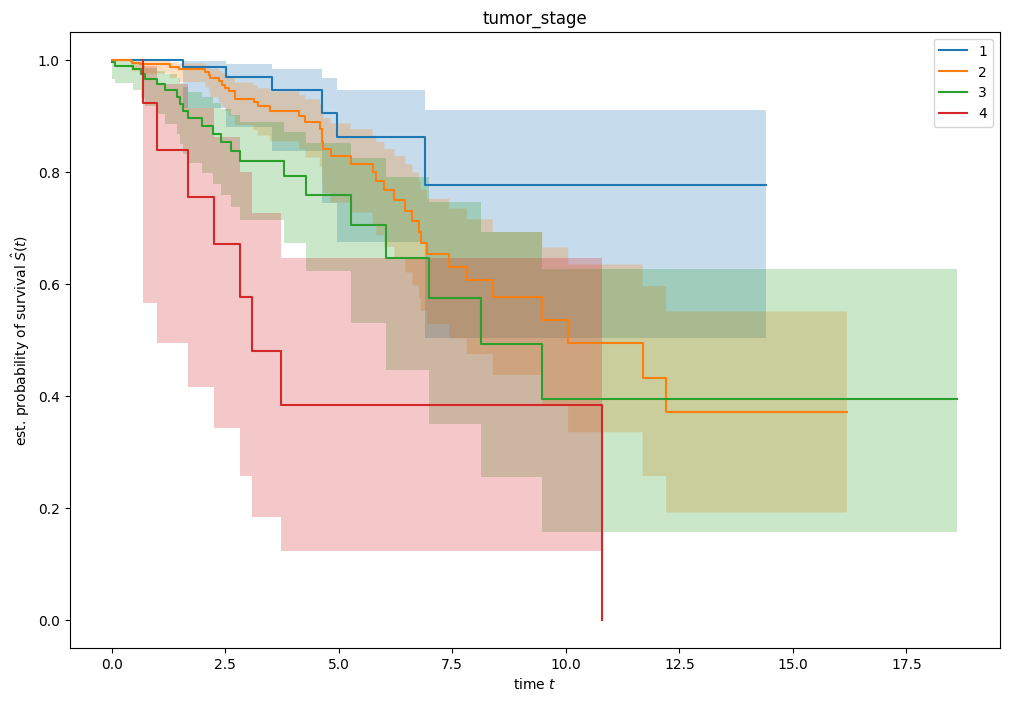

In [ ]:
#Tumor Stage Log-rank with 4 groups

tumorSorted = covariate.sort_values(by=['ajcc_pathologic_tumor_stage']).reset_index(drop=True)
x = tumorSorted[tumorSorted['ajcc_pathologic_tumor_stage']==1]
y = tumorSorted[tumorSorted['ajcc_pathologic_tumor_stage']==2]
z = tumorSorted[tumorSorted['ajcc_pathologic_tumor_stage']==3]
w = tumorSorted[tumorSorted['ajcc_pathologic_tumor_stage']==4]
x = x[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])
y = y[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])
z = z[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])
w = w[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])




fig, axes = plt.subplots(1, 1, figsize=(12, 8))

time, prob, conf_int = kaplan_meier_estimator(
        x['event'], x['time']/365, conf_type="log-log")

axes.step(time, prob, where="post", label="1")
axes.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time, prob, conf_int = kaplan_meier_estimator(
        y['event'], y['time']/365, conf_type="log-log")

axes.step(time, prob, where="post", label="2")
axes.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time, prob, conf_int = kaplan_meier_estimator(
        z['event'], z['time']/365, conf_type="log-log")

axes.step(time, prob, where="post", label="3")
axes.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time, prob, conf_int = kaplan_meier_estimator(
        w['event'], w['time']/365, conf_type="log-log")

axes.step(time, prob, where="post", label="4")
axes.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

axes.set_ylabel("est. probability of survival $\hat{S}(t)$")
axes.set_xlabel("time $t$")
axes.legend(loc="best")
plt.title(label='tumor_stage')
plt.show()




In [ ]:
#Multivariate Logrank for 4 Tumor Stages
!pip install lifelines
from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(tumorSorted['time'], tumorSorted['ajcc_pathologic_tumor_stage'], tumorSorted['event'])
final = results.summary
print(final['p'][0])
results.print_summary()
print(results.summary.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,))

8.571637879361888e-06


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          26.22 <0.005     16.83

\begin{tabular}{rrr}
\toprule
test_statistic & p & -log2(p) \\
\midrule
26.2 & 0.0 & 16.8 \\
\bottomrule
\end{tabular}



In [ ]:
#CoxPH Summary and Graphing

!pip install lifelines
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
import matplotlib.pyplot as plt

params2 = ["age_at_diagnosis", "ajcc_pathologic_tumor_stage", 'emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']
params = ["age_at_diagnosis", "ajcc_pathologic_tumor_stage", 'emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence', 'time', 'event']
cph = CoxPHFitter()
cph.fit(covariate[params], duration_col='time', event_col='event')

cph.print_summary()  # access the individual results using cph.summary

test = cph.summary
#print(test)
print(test.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,))

#cph.plot_partial_effects_on_outcome(covariates="age_at_diagnosis", values=[0, .25, .50, .75, 1.0], cmap='coolwarm')

# for i in params2:
#   plot = cph.plot_partial_effects_on_outcome(covariates=i, values=[-1, -.5, 0, .5, 1], cmap='coolwarm')
#   plt.savefig('/content/drive/MyDrive/Takeout/breastCancer/plots/' + i + '.png', bbox_inches='tight', dpi=300)

<lifelines.CoxPHFitter: fitted with 873 total observations, 795 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 873
number of events observed = 78
   partial log-likelihood = -362.72
         time fit was run = 2024-08-23 05:19:53 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
age_at_diagnosis              4.90     134.57       0.98             2.98             6.82                19.77               915.81
ajcc_pathologic_tumor_stage   0.75       2.11       0.16             0.44             1.05                 1.56                 2.87
emd                           1.22       3.38       0.57             0.11             2.33                 1.12                10.25
hausdorff                     0.07       1.08       0.20            -0.33             0.47                 0.72                 1.61
tumorDensity                 -0.34       0.71       0.21            -0.75             0.08                 0.47                 1.08
lymphoDensity                -0.79       0.45       0.51            -1.80             0.21                 0.17                 1.24
jaccard                       0.01       1.01       0.19            -0.36             0.39                 0.70                 1.48
mean_kde                     -8.94       0.00      11.49           -31.45            13.58                 0.00             7.88e+05
max_hausdorff                -0.49       0.61       0.37            -1.21             0.23                 0.30                 1.26
wasserstein                  -0.68       0.50       0.43            -1.52             0.15                 0.22                 1.16
log_density                  -0.51       0.60       0.26            -1.02             0.00                 0.36                 1.00
divergence                    0.42       1.53       0.23            -0.03             0.87                 0.97                 2.39

                              cmp to     z      p   -log2(p)
covariate                                                   
age_at_diagnosis                0.00  5.01 <0.005      20.81
ajcc_pathologic_tumor_stage     0.00  4.83 <0.005      19.46
emd                             0.00  2.16   0.03       5.01
hausdorff                       0.00  0.36   0.72       0.47
tumorDensity                    0.00 -1.58   0.11       3.14
lymphoDensity                   0.00 -1.54   0.12       3.02
jaccard                         0.00  0.07   0.94       0.09
mean_kde                        0.00 -0.78   0.44       1.20
max_hausdorff                   0.00 -1.32   0.19       2.43
wasserstein                     0.00 -1.61   0.11       3.21
log_density                     0.00 -1.95   0.05       4.30
divergence                      0.00  1.85   0.07       3.94
---
Concordance = 0.74
Partial AIC = 749.44
log-likelihood ratio test = 67.09 on 12 df
-log2(p) of ll-ratio test = 29.74

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & coef & exp(coef) & se(coef) & coef lower 95% & coef upper 95% & exp(coef) lower 95% & exp(coef) upper 95% & cmp to & z & p & -log2(p) \\
covariate &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
age_at_diagnosis & 4.90 & 134.57 & 0.98 & 2.98 & 6.82 & 19.77 & 915.81 & 0.00 & 5.01 & 0.00 & 20.81 \\
ajcc_pathologic_tumor_stage & 0.75 & 2.11 & 0.16 & 0.44 & 1.05 & 1.56 & 2.87 & 0.00 & 4.83 & 0.00 & 19.46 \\
emd & 1.22 & 3.38 & 0.57 & 0.11 & 2.33 & 1.12 & 10.25 & 0.00 & 2.16 & 0.03 & 5.01 \\
hausdorff & 0.07 & 1.08 & 0.20 & -0.33 & 0.47 & 0.72 & 1.61 & 0.00 & 0.36 & 0.72 & 0.47 \\
tumorDensity & -0.34 & 0.71 & 0.21 & -0.75 & 0.08 & 0.47 & 1.08 & 0.00 & -1.58 & 0.11 & 3.14 \\
lymphoDensity & -0.79 & 0.45 & 0.51 & -1.80 & 0.21 & 0.17 & 1.24 & 0.00 & -1.54 & 0.12 & 3.02 \\
jaccard & 0.01 & 1.01 & 0.19 & -0.36 & 0.39 & 0.70 & 1.48 & 0.00 & 0.07 & 0.94 & 0.09 \\
mean_kde & -8.94 & 0.00 & 11.49 & -31.45 & 13.58 & 0.00 & 788223.76 & 0.00 & -0.78 & 0.44 & 1.20

In [4]:
# 2. Create train and test datasets
df_train_c = pd.read_csv("/content/drive/MyDrive/Takeout/breastCancer/survival_train_ids_stratify.csv", index_col=0)
df_test_c = pd.read_csv("/content/drive/MyDrive/Takeout/breastCancer/survival_test_ids_stratify.csv", index_col=0)
df_train_c['histological_type'] = 1.0 * (df_train_c['histological_type'] == 'Infiltrating Ductal Carcinoma')
df_test_c['histological_type'] = 1.0 * (df_test_c['histological_type'] == 'Infiltrating Ductal Carcinoma')
print(f"train: {len(df_train_c)}, val: {len(df_test_c)}")

df_train_c.index.name = 'bcr_patient_barcode'
df_test_c.index.name = 'bcr_patient_barcode'
X_train = df_train_c[df_train_c.columns[2:]]
X_train = pd.merge(X_train, slides_info, how='inner', on='bcr_patient_barcode')
y_train = df_train_c[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])
X_test = df_test_c[df_test_c.columns[2:]]
X_test = pd.merge(X_test, slides_info, how='inner', on='bcr_patient_barcode')
y_test = df_test_c[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])
X_train = X_train.drop_duplicates(subset=['bcr_patient_barcode'])
X_test = X_test.drop_duplicates(subset=['bcr_patient_barcode'])
## Check time event status
y_events = y_train[y_train['event']]
train_min, train_max = y_events["time"].min(), y_events["time"].max()

y_events = y_test[y_test['event']]
test_min, test_max = y_events["time"].min(), y_events["time"].max()
print(train_min, train_max, test_min, test_max)

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

# auc_times = np.percentile(y_train["time"], np.linspace(5, 99.0, 50))
va_times = np.percentile(y_test["time"], np.linspace(5, 99.0, 50))
# va_times = np.arange(test_min, test_max, 50)
print(va_times)


train: 658, val: 164
1.0 4456.0 426.0 3941.0
[  10.15         17.93857143   32.6155102    51.24653061   72.6577551
  122.92346939  140.91163265  160.34714286  181.66204082  200.09428571
  218.67755102  243.01918367  267.67326531  274.          295.90714286
  325.05408163  339.35326531  369.61591837  396.          422.49469388
  447.19897959  486.63142857  515.19714286  549.62632653  597.55489796
  624.85204082  645.35122449  738.77346939  756.86        799.74265306
  828.91632653  870.82959184  944.81673469 1018.1355102  1093.38653061
 1150.         1172.71979592 1289.05285714 1351.68408163 1432.32632653
 1579.69489796 1656.00469388 1779.84857143 1890.97734694 2074.32387755
 2343.23469388 2509.98326531 2766.49612245 3571.62061224 4995.77      ]


In [7]:
# Kaplan Meier - Uncomment to save graphs
!pip install lifelines
import matplotlib
from lifelines.statistics import logrank_test

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

params = ["age_at_diagnosis", "ajcc_pathologic_tumor_stage", 'emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']

for i in params:
  tumorSorted = covariate.sort_values(by=[i]).reset_index(drop=True)
  tumorSorted = tumorSorted[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])
  x = tumorSorted[436:]
  y = tumorSorted[:436]

  results = logrank_test(x['time'], y['time'], event_observed_A=x['event'], event_observed_B=y['event'])
  final = results.summary
  final['attribute'] = i
  pvalue = final['p'][0]
  print(final.to_latex())
  #results.print_summary()

  # fig, axes = plt.subplots(1, 1, figsize=(12, 8))

  # time, prob, conf_int = kaplan_meier_estimator(
  #         x['event'], x['time']/365, conf_type="log-log")

  # axes.step(time, prob, where="post", label="upper half")
  # axes.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

  # time, prob, conf_int = kaplan_meier_estimator(
  #         y['event'], y['time']/365, conf_type="log-log")

  # axes.step(time, prob, where="post", label="lower half")
  # axes.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

  # axes.set_ylabel("est. probability of survival $\hat{S}(t)$")
  # axes.set_xlabel("time $t$")
  # axes.legend(loc="best")
  # plt.title(label=(i+' - p-value = '+str(pvalue)))
  # plt.savefig('/content/drive/MyDrive/Takeout/breastCancer/plots/' + i + '.pdf', bbox_inches='tight')
  # plt.show()




  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=0fd125072492730ebee4a1aee10ebf1c1c0291e3c67f1a587f4978f3354aa9d0
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
\begin{tabular}{lrrrl}
\toprule
 & test_statistic & p & -log2(p) & attribute \\
\midrule
0 & 6.342444 & 0.011788 & 6.406509 & age_at_diagnosis \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrl}
\toprule
 & test_statistic & p & -log2(p) & attribute \\
\midrule
0 & 0.938767 & 0.332595 & 1.588161 & ajcc_pathologic_tumor_stage \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrl}
\toprule
 & test_statistic & p & -log2(p) & attribute \\
\midrule
0 & 2.894660 & 0.088874 & 3.492102 & emd \\
\bot

In [ ]:
  tumorSorted

rec.array([(False, 1.700e+02), (False, 9.600e+01), ( True, 2.127e+03),
           (False, 3.400e+01), (False, 2.930e+02), (False, 1.004e+03),
           (False, 1.642e+03), (False, 3.520e+02), (False, 1.228e+03),
           (False, 4.850e+02), (False, 4.040e+02), ( True, 9.430e+02),
           (False, 1.228e+03), (False, 2.000e+02), (False, 2.740e+02),
           (False, 1.930e+02), ( True, 2.361e+03), (False, 3.000e+01),
           ( True, 2.660e+02), ( True, 9.590e+02), ( True, 3.650e+02),
           (False, 7.630e+02), (False, 1.400e+01), (False, 2.730e+02),
           (False, 1.000e+00), (False, 6.100e+01), (False, 1.288e+03),
           (False, 4.280e+02), (False, 1.000e+01), ( True, 8.790e+02),
           (False, 2.670e+02), (False, 8.290e+02), (False, 7.000e+00),
           ( True, 3.941e+03), (False, 2.580e+02), (False, 1.500e+02),
           (False, 1.173e+03), (False, 1.247e+03), (False, 1.271e+03),
           (False, 7.460e+02), (False, 4.410e+02), (False, 9.720e+02),
      

/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


clinical: alpha=0.18420699693267145, C-Index(cv)=0.7745936412031448, C-Index(train)=0.7886432738926781, C-Index(test)=0.7247109826589595, C-Index_recal(test)=(0.7247109826589595, 498, 187, 7, 0), AUC(test)=0.7687082508286511 (se=0.019810301331856964)


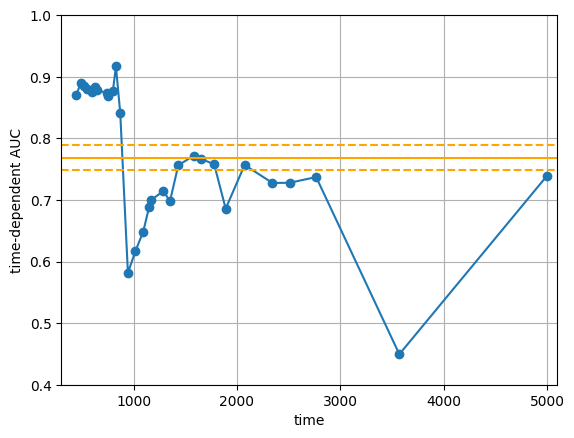

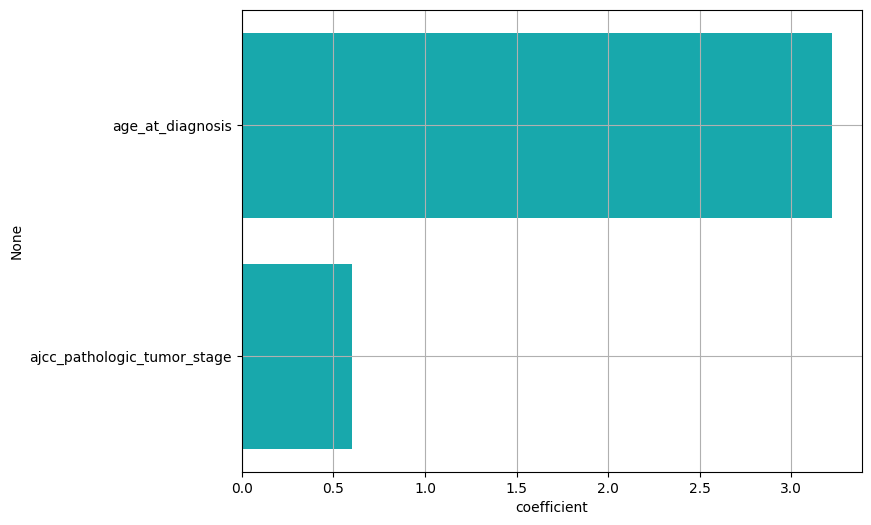

ajcc_pathologic_tumor_stage0.161 +/- 0.045
age_at_diagnosis0.050 +/- 0.049


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


derived: alpha=0.0001, C-Index(cv)=0.6097082712594284, C-Index(train)=0.6606130331169365, C-Index(test)=0.46965317919075145, C-Index_recal(test)=(0.46965317919075145, 325, 367, 0, 0), AUC(test)=0.47560912460348587 (se=0.025935570167869758)


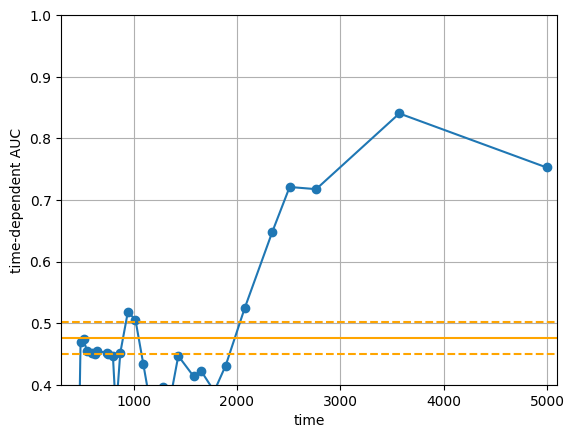

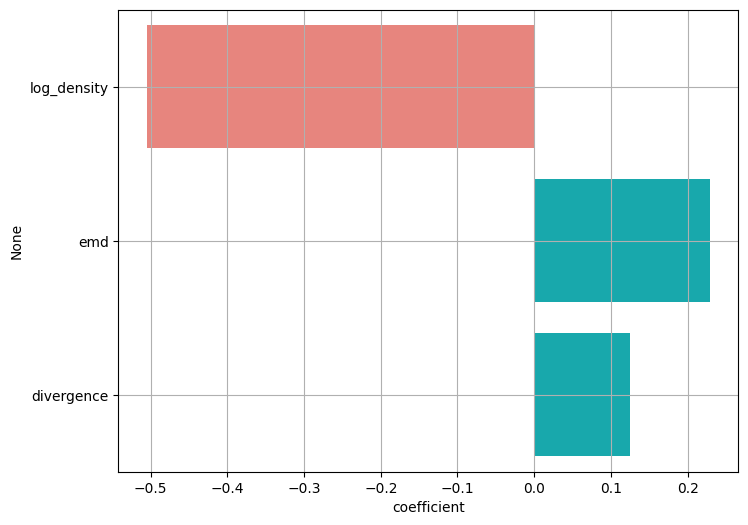

divergence-0.014 +/- 0.026
emd     -0.028 +/- 0.056
log_density-0.036 +/- 0.063


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


derived_base: alpha=0.019306977288832496, C-Index(cv)=0.7791014238822431, C-Index(train)=0.8089407510888322, C-Index(test)=0.6676300578034682, C-Index_recal(test)=(0.6676300578034682, 462, 230, 0, 0), AUC(test)=0.7068498506600317 (se=0.016536806165823408)


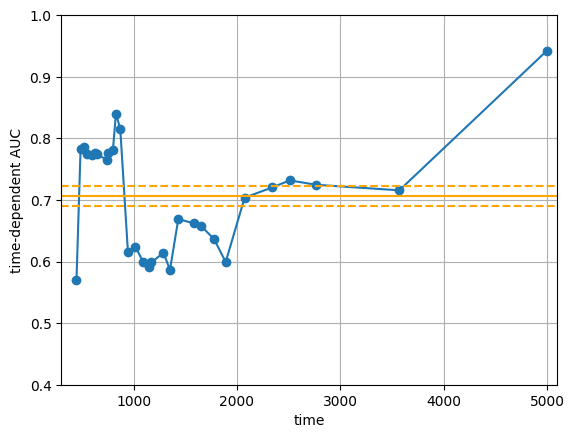

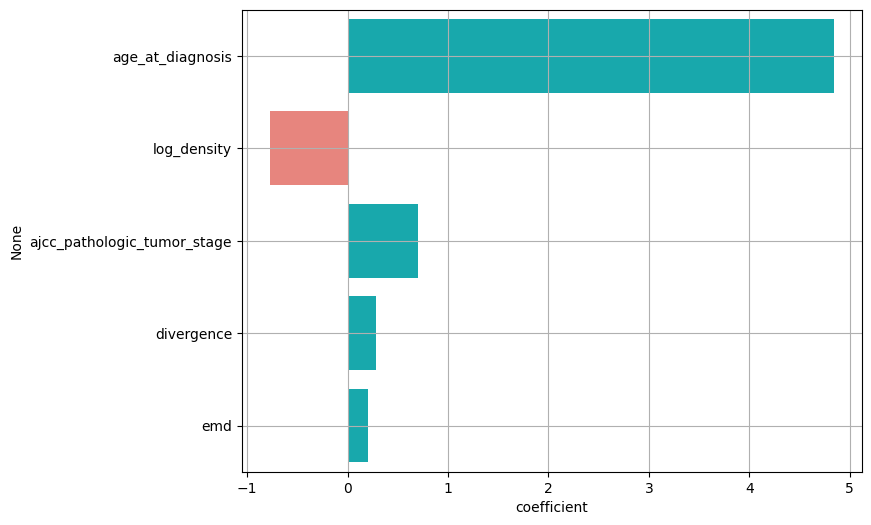

ajcc_pathologic_tumor_stage0.143 +/- 0.034
age_at_diagnosis0.045 +/- 0.063
divergence0.024 +/- 0.024
emd     -0.000 +/- 0.025
log_density-0.009 +/- 0.044


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


max_derived: alpha=0.02811768697974228, C-Index(cv)=0.7660894236607609, C-Index(train)=0.8092694551729805, C-Index(test)=0.7008670520231214, C-Index_recal(test)=(0.7008670520231214, 485, 207, 0, 0), AUC(test)=0.7420454895037334 (se=0.015586720994839699)


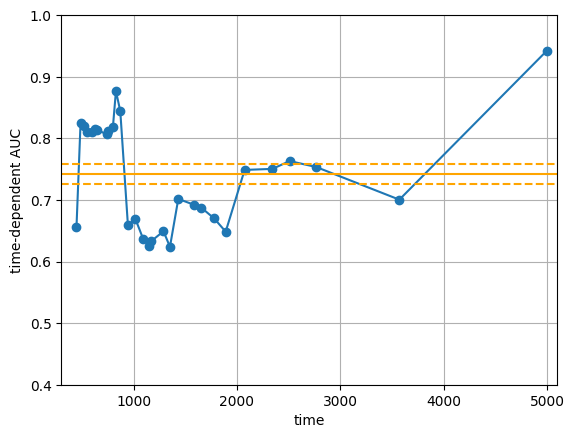

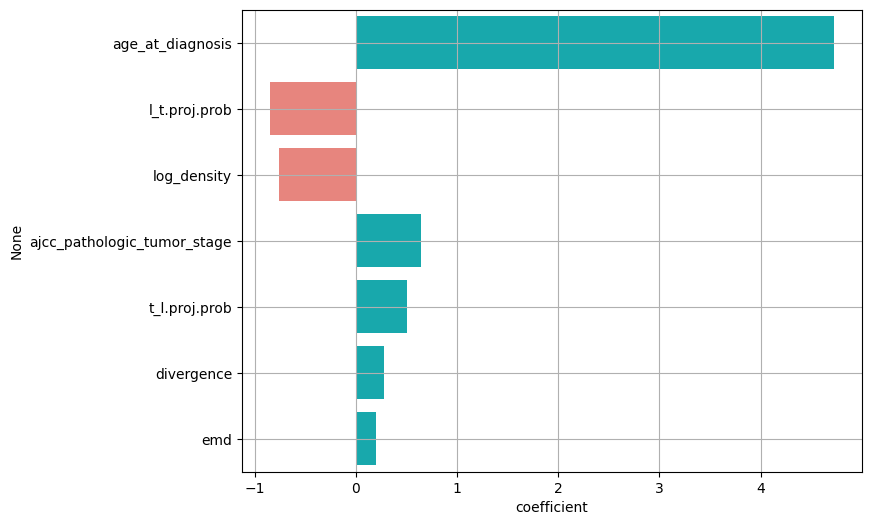

ajcc_pathologic_tumor_stage0.146 +/- 0.033
age_at_diagnosis0.044 +/- 0.062
t_l.proj.prob0.029 +/- 0.009
divergence0.025 +/- 0.025
l_t.proj.prob0.005 +/- 0.003
log_density-0.001 +/- 0.042
emd     -0.005 +/- 0.025


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


clinical + TME v1: alpha=0.8286427728546842, C-Index(cv)=0.7686851066687317, C-Index(train)=0.7962856438491248, C-Index(test)=0.7456647398843931, C-Index_recal(test)=(0.7456647398843931, 516, 176, 0, 0), AUC(test)=0.7904085433321847 (se=0.014855711848797009)


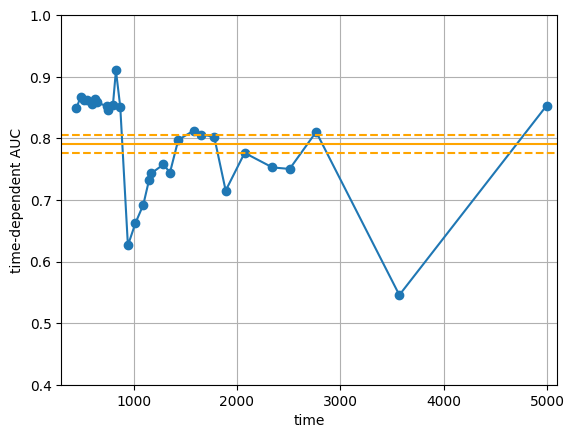

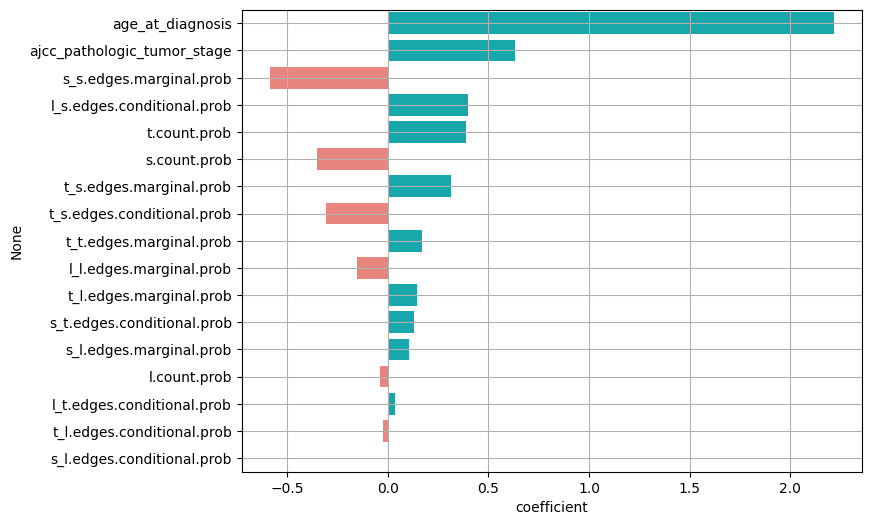

ajcc_pathologic_tumor_stage0.172 +/- 0.045
age_at_diagnosis0.036 +/- 0.034
t.count.prob0.013 +/- 0.007
s_s.edges.marginal.prob0.009 +/- 0.007
s.count.prob0.008 +/- 0.005
t_t.edges.marginal.prob0.006 +/- 0.004
l.count.prob0.001 +/- 0.001
l_l.edges.marginal.prob0.001 +/- 0.001
s_l.edges.conditional.prob0.000 +/- 0.001
l_t.edges.conditional.prob-0.000 +/- 0.001
s_l.edges.marginal.prob-0.001 +/- 0.001
t_l.edges.conditional.prob-0.001 +/- 0.001
t_l.edges.marginal.prob-0.001 +/- 0.001
s_t.edges.conditional.prob-0.002 +/- 0.004
t_s.edges.marginal.prob-0.002 +/- 0.003
l_s.edges.conditional.prob-0.003 +/- 0.002
t_s.edges.conditional.prob-0.006 +/- 0.004


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


clinical + TME v2: alpha=0.2682695795279725, C-Index(cv)=0.7765796401953897, C-Index(train)=0.8093516311940175, C-Index(test)=0.7557803468208093, C-Index_recal(test)=(0.7557803468208093, 523, 169, 0, 0), AUC(test)=0.802574256889377 (se=0.016911675991321064)


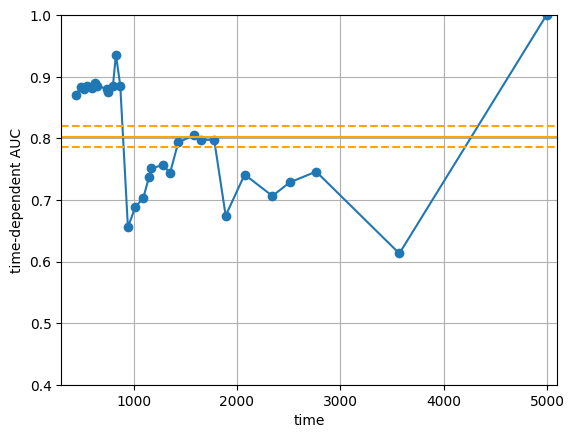

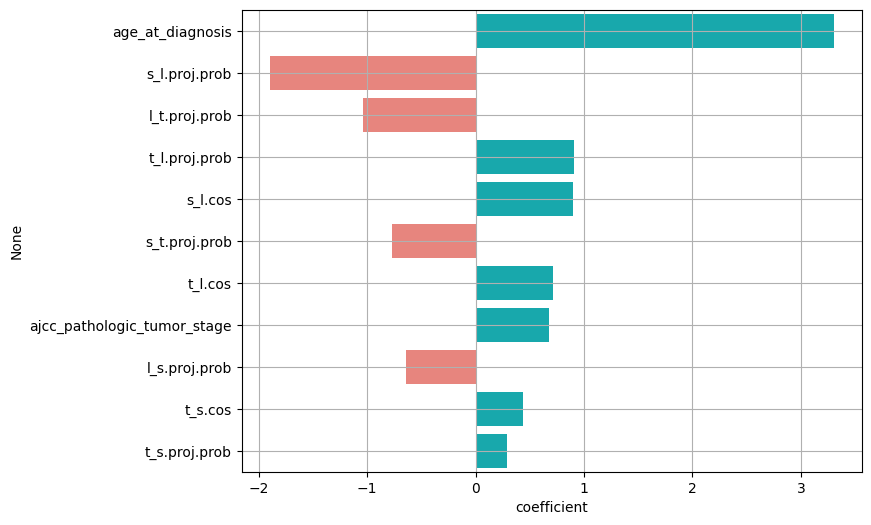

ajcc_pathologic_tumor_stage0.127 +/- 0.042
t_l.proj.prob0.046 +/- 0.016
age_at_diagnosis0.031 +/- 0.038
s_t.proj.prob0.013 +/- 0.005
s_l.cos 0.009 +/- 0.009
l_t.proj.prob0.005 +/- 0.005
t_s.proj.prob0.005 +/- 0.005
t_l.cos 0.000 +/- 0.010
l_s.proj.prob0.000 +/- 0.006
t_s.cos -0.013 +/- 0.006
s_l.proj.prob-0.040 +/- 0.023


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


clinical + set_1 + set_2: alpha=0.5689866029018293, C-Index(cv)=0.7663588272660113, C-Index(train)=0.8150217766455748, C-Index(test)=0.7456647398843931, C-Index_recal(test)=(0.7456647398843931, 516, 176, 0, 0), AUC(test)=0.7988007578527477 (se=0.017629825462676423)


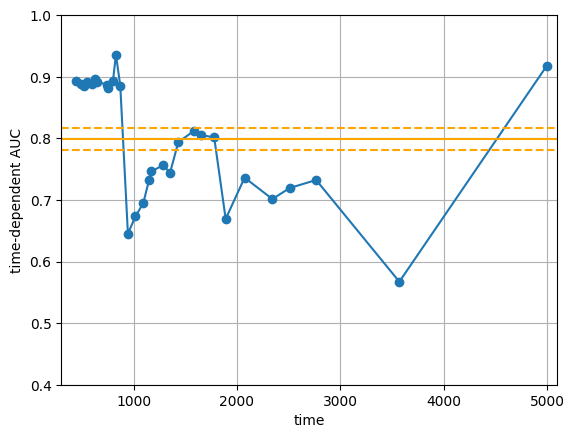

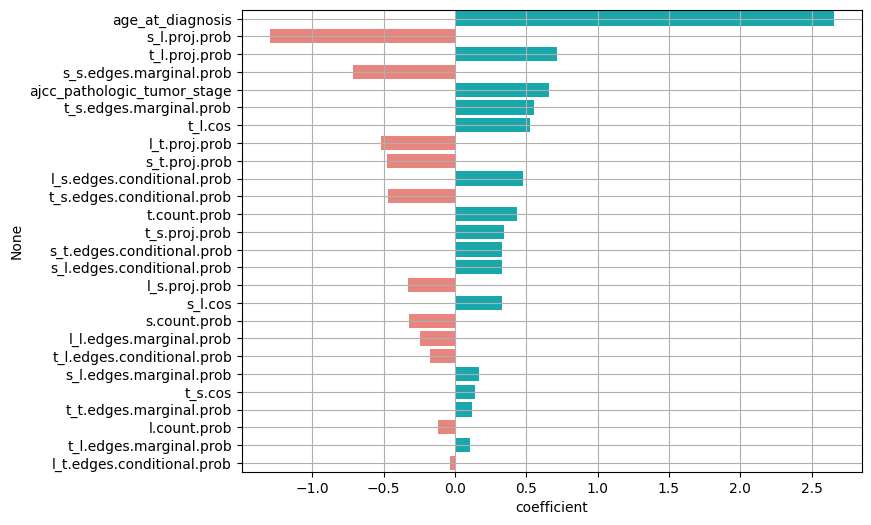

ajcc_pathologic_tumor_stage0.155 +/- 0.046
t_l.proj.prob0.041 +/- 0.013
age_at_diagnosis0.029 +/- 0.037
t.count.prob0.013 +/- 0.006
s_s.edges.marginal.prob0.009 +/- 0.007
t_s.proj.prob0.007 +/- 0.005
s.count.prob0.007 +/- 0.005
s_t.proj.prob0.007 +/- 0.003
t_t.edges.marginal.prob0.004 +/- 0.003
l_s.proj.prob0.002 +/- 0.003
l_t.proj.prob0.002 +/- 0.003
s_l.cos 0.001 +/- 0.004
l_t.edges.conditional.prob-0.000 +/- 0.000
t_l.cos -0.000 +/- 0.005
l_l.edges.marginal.prob-0.001 +/- 0.001
l.count.prob-0.001 +/- 0.001
s_l.edges.marginal.prob-0.002 +/- 0.002
t_l.edges.marginal.prob-0.002 +/- 0.001
t_s.cos -0.003 +/- 0.002
l_s.edges.conditional.prob-0.007 +/- 0.004
s_t.edges.conditional.prob-0.007 +/- 0.003
t_s.edges.marginal.prob-0.009 +/- 0.004
t_l.edges.conditional.prob-0.012 +/- 0.005
t_s.edges.conditional.prob-0.012 +/- 0.005
s_l.edges.conditional.prob-0.013 +/- 0.007
s_l.proj.prob-0.029 +/- 0.014


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


clinical + selected TME: alpha=0.5689866029018293, C-Index(cv)=0.7662068198581313, C-Index(train)=0.7920946667762347, C-Index(test)=0.7586705202312138, C-Index_recal(test)=(0.7586705202312138, 525, 167, 0, 0), AUC(test)=0.7998923329182543 (se=0.01616617745495823)


<ipython-input-8-f8e47a3aea0d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
<ipython-input-8-f8e47a3aea0d>:99: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,


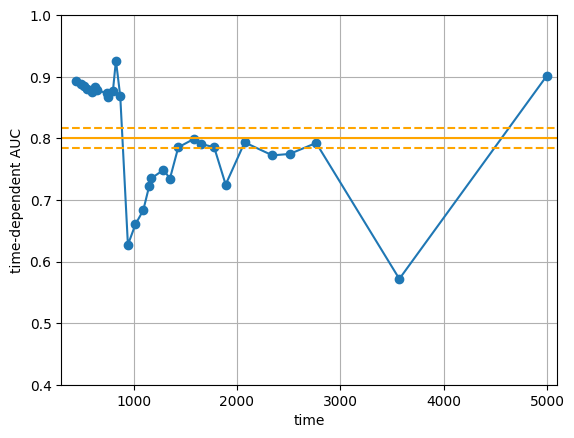

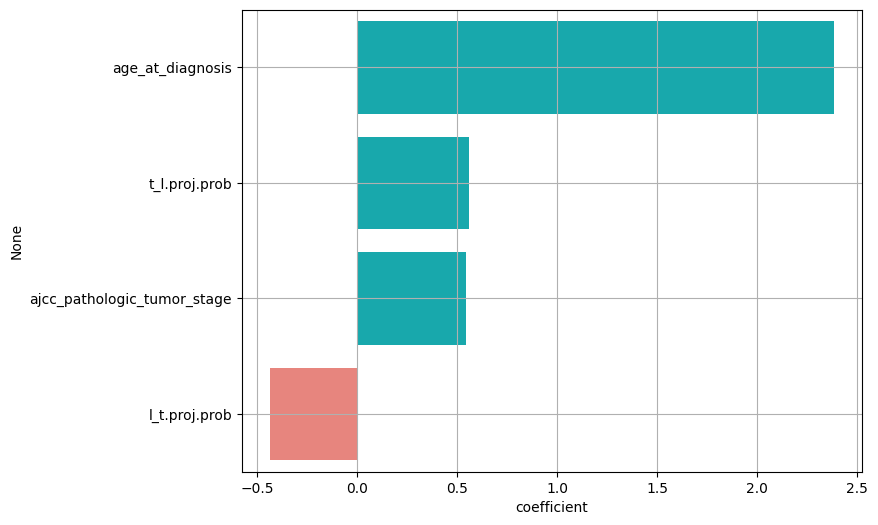

ajcc_pathologic_tumor_stage0.137 +/- 0.043
t_l.proj.prob0.030 +/- 0.009
age_at_diagnosis0.025 +/- 0.037
l_t.proj.prob0.001 +/- 0.004


,coefficient
age_at_diagnosis,2.3825
t_l.proj.prob,0.5585
ajcc_pathologic_tumor_stage,0.5474
l_t.proj.prob,-0.4342


,alpha,cv C-Index,train C-Index,test C-Index,test C-Index recal,test AUC mean,test AUC se
clinical,0.1842,0.7746,0.7886,0.7247,"(0.7247109826589595, 498, 187, 7, 0)",0.7687,0.0198
derived,0.0001,0.6097,0.6606,0.4697,"(0.46965317919075145, 325, 367, 0, 0)",0.4756,0.0259
derived_base,0.0193,0.7791,0.8089,0.6676,"(0.6676300578034682, 462, 230, 0, 0)",0.7068,0.0165
max_derived,0.0281,0.7661,0.8093,0.7009,"(0.7008670520231214, 485, 207, 0, 0)",0.7420,0.0156
clinical + TME v1,0.8286,0.7687,0.7963,0.7457,"(0.7456647398843931, 516, 176, 0, 0)",0.7904,0.0149
clinical + TME v2,0.2683,0.7766,0.8094,0.7558,"(0.7557803468208093, 523, 169, 0, 0)",0.8026,0.0169
clinical + set_1 + set_2,0.5690,0.7664,0.8150,0.7457,"(0.7456647398843931, 516, 176, 0, 0)",0.7988,0.0176
clinical + selected TME,0.5690,0.7662,0.7921,0.7587,"(0.7586705202312138, 525, 167, 0, 0)",0.7999,0.0162


In [8]:

random_state = 42
from sklearn.inspection import permutation_importance

    ## penalized CoxPH survival
base = [
    "age_at_diagnosis", "ajcc_pathologic_tumor_stage",
    #"er_status_by_ihc", "pr_status_by_ihc", "her2_status_by_ihc",
]

#derived = ['emd', 'hausdorff', 'tumorDensity', 'lymphoDensity', 'jaccard', 'mean_kde', 'max_hausdorff', 'wasserstein', 'log_density', 'divergence']
derived = ['emd', 'divergence', 'log_density']
set_1 = [
    't.count.prob', 's.count.prob', 'l.count.prob',
    't_t.edges.marginal.prob', 't_s.edges.marginal.prob', 't_l.edges.marginal.prob',
    's_s.edges.marginal.prob', 's_l.edges.marginal.prob', 'l_l.edges.marginal.prob',
    't_s.edges.conditional.prob', 't_l.edges.conditional.prob', 's_t.edges.conditional.prob',
    's_l.edges.conditional.prob', 'l_t.edges.conditional.prob', 'l_s.edges.conditional.prob',
]

# density features
set_2 = [
    't_s.cos', 't_l.cos', 's_l.cos',
    't_s.proj.prob', 's_t.proj.prob', 't_l.proj.prob', 'l_t.proj.prob', 's_l.proj.prob', 'l_s.proj.prob',
]

feature_sets = {
    'clinical': base,
    # 'set_1': set_1,
    # 'set_2': set_2,
    'derived': derived,
    'derived_base': derived + base,
    'max_derived': derived + base + ['l_t.proj.prob', 't_l.proj.prob', ],
    'clinical + TME v1': base + set_1,
    'clinical + TME v2': base + set_2,
    'clinical + set_1 + set_2': base + set_1 + set_2,
    'clinical + selected TME': base + ['l_t.proj.prob', 't_l.proj.prob', ]
}

df_summary, df_export = {}, {}
for k, fset in feature_sets.items():
    print("================================")

    estimated_alphas = 10. ** np.linspace(-4, 4, 50)
    # estimated_alphas = np.array([0.])
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    gcv = GridSearchCV(
        make_pipeline(CoxPHSurvivalAnalysis()),  # StandardScaler(),
        param_grid={"coxphsurvivalanalysis__alpha": estimated_alphas},
        cv=cv, error_score=0.5, n_jobs=-1).fit(X_train[fset], y_train)

    best_alpha = gcv.best_params_['coxphsurvivalanalysis__alpha']
    best_model = gcv.best_estimator_.named_steps["coxphsurvivalanalysis"]
    cv_score = gcv.best_score_
    train_score = best_model.score(X_train[fset], y_train)
    test_score = best_model.score(X_test[fset], y_test)

    ## calculate scores
    y_predict = best_model.predict(X_test[fset])
    aucs, _ = cumulative_dynamic_auc(y_train, y_test, y_predict, va_times,)
    auc_mean, auc_se = np.nanmean(aucs), np.nanstd(aucs)/np.sqrt((~np.isnan(aucs)).sum())
#     c_index = concordance_index_ipcw(y_train, y_test, y_predict, tau=None)
    c_index = concordance_index_censored(y_test['event'], y_test['time'], y_predict)

    plt.plot(va_times, aucs, marker="o")
    plt.axhline(auc_mean, linestyle="-", c='orange')
    plt.axhline(auc_mean-auc_se, linestyle="--", c='orange')
    plt.axhline(auc_mean+auc_se, linestyle="--", c='orange')
    plt.xlabel("time")
    plt.xlim(300, 5100)
    plt.ylabel("time-dependent AUC")
    plt.ylim(0.4, 1.00)
    plt.grid(True)

    print((
        f"{k}: alpha={best_alpha}, C-Index(cv)={cv_score}, " +
        f"C-Index(train)={train_score}, C-Index(test)={test_score}, " +
        f"C-Index_recal(test)={c_index}, " +
        f"AUC(test)={auc_mean} (se={auc_se})"
    ))

    df_summary[k] = {'alpha': best_alpha, 'cv C-Index': cv_score,
                     'train C-Index': train_score, 'test C-Index': test_score,
                     'test C-Index recal': c_index, 'test AUC mean': auc_mean, 'test AUC se': auc_se,
                    }
    df_export = pd.concat([
        pd.DataFrame([{'x': x, 'event': event, 'time': time, 'trainval': 1}
                      for x, (event, time) in zip(best_model.predict(X_train[fset]), y_train)]),
        pd.DataFrame([{'x': x, 'event': event, 'time': time, 'trainval': 0}
                      for x, (event, time) in zip(best_model.predict(X_test[fset]), y_test)]),
    ])
    df_export.to_csv(os.path.join(OUTPUT_FOLDER, f"IDC_ILC.{k}.csv"))

    best_coefs = pd.DataFrame(best_model.coef_, index=fset, columns=["coefficient"])
    coef_order = best_coefs.abs().sort_values("coefficient", ascending=False).index
    best_coefs = best_coefs.loc[coef_order]

    _, ax = plt.subplots(figsize=(8, 6))
    # best_coefs.plot.barh(ax=ax, legend=False, color=np.where(best_coefs['coefficient'] > 0, 'green', 'red'))
    sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
                palette=np.where(best_coefs['coefficient'] > 0, "#00BFC4", "#F8766D"))
    ax.set_xlabel("coefficient")
    ax.grid(True)
    plt.show()

    r = permutation_importance(best_model, X_test[fset], y_test,
                           n_repeats=15,
                           random_state=random_state)
    for i in r.importances_mean.argsort()[::-1]:
      #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{fset[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
    #perm = PermutationImportance(best_model, n_iter=15, random_state=random_state)
    #perm.fit(X_test[fset], y_test)
    #display(eli5.show_weights(perm, feature_names=fset, top=100))

best_coefs_stratify = best_coefs
display(best_coefs_stratify)
display(pd.DataFrame.from_dict(df_summary, 'index'))

In [ ]:
## IDC only
df_train_c = pd.read_csv("survival_train_ids_IDC.csv", index_col=0)
df_test_c = pd.read_csv("survival_test_ids_IDC.csv", index_col=0)
df_train_c['histological_type'] = 1.0 * (df_train_c['histological_type'] == 'Infiltrating Ductal Carcinoma')
df_test_c['histological_type'] = 1.0 * (df_test_c['histological_type'] == 'Infiltrating Ductal Carcinoma')
print(f"train: {len(df_train_c)}, val: {len(df_test_c)}")

X_train = df_train_c[df_train_c.columns[2:]]
y_train = df_train_c[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])
X_test = df_test_c[df_test_c.columns[2:]]
y_test = df_test_c[['event', 'time']].to_records(index=False).astype([('event', '?'), ('time', '<f8')])


## Check time event status
y_events = y_train[y_train['event']]
train_min, train_max = y_events["time"].min(), y_events["time"].max()

y_events = y_test[y_test['event']]
test_min, test_max = y_events["time"].min(), y_events["time"].max()
print(train_min, train_max, test_min, test_max)

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

# auc_times = np.percentile(y_train["time"], np.linspace(5, 99.0, 50))
va_times = np.percentile(y_test["time"], np.linspace(5, 99.0, 50))
# va_times = np.arange(test_min, test_max, 50)
print(va_times)


In [ ]:
## penalized CoxPH survival
base = [
    "age_at_diagnosis", "ajcc_pathologic_tumor_stage",
    "er_status_by_ihc", "pr_status_by_ihc", "her2_status_by_ihc",
]

set_1 = [
    't.count.prob', 's.count.prob', 'l.count.prob',
    't_t.edges.marginal.prob', 't_s.edges.marginal.prob', 't_l.edges.marginal.prob',
    's_s.edges.marginal.prob', 's_l.edges.marginal.prob', 'l_l.edges.marginal.prob',
    't_s.edges.conditional.prob', 't_l.edges.conditional.prob', 's_t.edges.conditional.prob',
    's_l.edges.conditional.prob', 'l_t.edges.conditional.prob', 'l_s.edges.conditional.prob',
]

# density features
set_2 = [
    't_s.cos', 't_l.cos', 's_l.cos',
    't_s.proj.prob', 's_t.proj.prob', 't_l.proj.prob', 'l_t.proj.prob', 's_l.proj.prob', 'l_s.proj.prob',
]

feature_sets = {
    'clinical': base,
    # 'set_1': set_1,
    # 'set_2': set_2,
    'clinical + TME v1': base + set_1,
    'clinical + TME v2': base + set_2,
    'clinical + set_1 + set_2': base + set_1 + set_2,
    'clinical + selected TME': base + ['l_t.proj.prob', 't_l.proj.prob', ],
    # ["age_at_diagnosis", "ajcc_pathologic_tumor_stage", "pr_status_by_ihc", "her2_status_by_ihc"]
}

df_summary = {}
for k, fset in feature_sets.items():
    print("================================")

    estimated_alphas = 10. ** np.linspace(-4, 4, 50)
    # estimated_alphas = np.array([0.])
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    gcv = GridSearchCV(
        make_pipeline(CoxPHSurvivalAnalysis()),  # StandardScaler(),
        param_grid={"coxphsurvivalanalysis__alpha": estimated_alphas},
        cv=cv, error_score=0.5, n_jobs=-1).fit(X_train[fset], y_train)

    best_alpha = gcv.best_params_['coxphsurvivalanalysis__alpha']
    best_model = gcv.best_estimator_.named_steps["coxphsurvivalanalysis"]
    cv_score = gcv.best_score_
    train_score = best_model.score(X_train[fset], y_train)
    test_score = best_model.score(X_test[fset], y_test)

    ## calculate scores
    y_predict = best_model.predict(X_test[fset])
    aucs, _ = cumulative_dynamic_auc(y_train, y_test, y_predict, va_times,)
    auc_mean, auc_se = np.nanmean(aucs), np.nanstd(aucs)/np.sqrt((~np.isnan(aucs)).sum())
#     c_index = concordance_index_ipcw(y_train, y_test, y_predict, tau=None)
    c_index = concordance_index_censored(y_test['event'], y_test['time'], y_predict)

    plt.plot(va_times, aucs, marker="o")
    plt.axhline(auc_mean, linestyle="-", c='orange')
    plt.axhline(auc_mean-auc_se, linestyle="--", c='orange')
    plt.axhline(auc_mean+auc_se, linestyle="--", c='orange')
    plt.xlabel("time")
    plt.xlim(300, 5100)
    plt.ylabel("time-dependent AUC")
    plt.ylim(0.55, 1.00)
    plt.grid(True)

    print((
        f"{k}: alpha={best_alpha}, C-Index(cv)={cv_score}, " +
        f"C-Index(train)={train_score}, C-Index(test)={test_score}, " +
        f"C-Index_recal(test)={c_index}, " +
        f"AUC(test)={auc_mean} (se={auc_se})"
    ))

    df_summary[k] = {'alpha': best_alpha, 'cv C-Index': cv_score,
                     'train C-Index': train_score, 'test C-Index': test_score,
                     'test C-Index recal': c_index, 'test AUC mean': auc_mean, 'test AUC se': auc_se,
                    }

    df_export = pd.concat([
        pd.DataFrame([{'x': x, 'event': event, 'time': time, 'trainval': 1}
                      for x, (event, time) in zip(best_model.predict(X_train[fset]), y_train)]),
        pd.DataFrame([{'x': x, 'event': event, 'time': time, 'trainval': 0}
                      for x, (event, time) in zip(best_model.predict(X_test[fset]), y_test)]),
    ])
    df_export.to_csv(os.path.join(OUTPUT_FOLDER, f"IDC_only.{k}.csv"))

    best_coefs = pd.DataFrame(best_model.coef_, index=fset, columns=["coefficient"])
    coef_order = best_coefs.abs().sort_values("coefficient", ascending=False).index
    best_coefs = best_coefs.loc[coef_order]

    _, ax = plt.subplots(figsize=(8, 6))
    # best_coefs.plot.barh(ax=ax, legend=False, color=np.where(best_coefs['coefficient'] > 0, 'green', 'red'))
    sns.barplot(ax=ax, x=best_coefs['coefficient'], y=best_coefs.index,
                palette=np.where(best_coefs['coefficient'] > 0, "#00BFC4", "#F8766D"))
    ax.set_xlabel("coefficient")
    ax.grid(True)
    plt.show()

    perm = PermutationImportance(best_model, n_iter=15, random_state=random_state)
    perm.fit(X_test[fset], y_test)
    display(eli5.show_weights(perm, feature_names=fset, top=100))

best_coefs_IDC = best_coefs
display(best_coefs_IDC)
display(pd.DataFrame.from_dict(df_summary, 'index'))

In [ ]:
best_coefs_merge = pd.concat([best_coefs_IDC.reset_index(), best_coefs_stratify.reset_index()], axis=0)
best_coefs_merge['model'] = ['IDC'] * len(best_coefs_IDC) + ['Stratify'] * len(best_coefs_stratify)

_, ax = plt.subplots(figsize=(8, 6))
sns.barplot(ax=ax, x=best_coefs_merge['coefficient'], y=best_coefs_merge['index'],
            hue=best_coefs_merge['model'], )
            # palette=np.where(best_coefs['coefficient'] > 0, "#00BFC4", "#F8766D"))
ax.set_xlabel("coefficient")
ax.grid(True)
plt.show()

In [ ]:
scores = best_model.predict(X_train[fset])
preds = pd.DataFrame([{'score': score, 'event': event, 'time': time, 'trainval': 1}
                      for score, (event, time) in zip(scores, y_train)])
preds.index = X_train.index

explore_df = pd.concat([preds, X_train[['age_at_diagnosis', 'l_t.proj.prob', 't_l.proj.prob', 't_l.cos']]], axis=1)

explore_df.loc[explore_df['l_t.proj.prob'] > 0.1,]
